# HW 6 - Multivariate regression - aragonite saturation state

In [1]:
%matplotlib notebook 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cbsyst as cb #cbsyst = carbon and boron system
import statsmodels as sm
from statsmodels.api import OLS


#load in data
filename = 'WCOA2013_hy1.csv'
df = pd.read_csv(filename,header=31,na_values = -999,parse_dates=[[8,9]])
df.head()

C:\Users\Miya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,DATE_TIME,EXPOCODE,SECT_ID,LEG,LINE,STNNBR,CASTNO,BTLNBR,BTLNBR_FLAG_W,LATITUDE,...,TCARBN,TCARBN_FLAG_W,ALKALI,ALKALI_FLAG_W,PH_TOT,PH_TOT_FLAG_W,PH_TMP,CO32,CO32__FLAG_W,CHLORA
0,2013-08-05 02:12:20,317W20130803,WCOA2013,1,2,11,1,1,2,48.2,...,2370.2,2,2369.0,2,7.294,2,25.0,NaN,9,NaN
1,2013-08-05 02:12:53,317W20130803,WCOA2013,1,2,11,1,2,2,48.2,...,NaN,9,NaN,9,7.295,2,25.0,NaN,9,NaN
2,2013-08-05 02:19:58,317W20130803,WCOA2013,1,2,11,1,3,2,48.2,...,2349.6,2,2343.7,2,7.282,2,25.0,43.521,3,NaN
3,2013-08-05 02:27:01,317W20130803,WCOA2013,1,2,11,1,4,2,48.2,...,2318.7,2,2311.9,2,7.287,2,25.0,45.641,2,NaN
4,2013-08-05 02:30:53,317W20130803,WCOA2013,1,2,11,1,5,2,48.2,...,2300.0,2,2299.7,2,7.308,2,25.0,47.741,2,NaN


In [2]:
#get some carbon system variables using cb.Cysys
Csw = cb.Csys(pH=df['PH_TOT'],TA=df['ALKALI'],T=df['CTDTMP'],S=df['CTDSAL'],P=df['CTDPRS'])
#Inputs: pH, TA=total alkalinity, T=Temperature, S=Salinity, P=pressure


#calculate OmegaA, aragonite saturation state
OmegaA = Csw['Ca']*Csw['CO3']/(Csw.Ks['KspA']*1e6) 
#put this in the data frame for consistency and so pandas keeps track of it with other vars
df['OmegaA']=OmegaA 

In [3]:
#get finite and 30 > pressure > 300 index (minimize localized effects of surface warming, gas exchange and riverine inputs)
jj = (df['CTDPRS']>30) & (df['CTDPRS']<300) & np.isfinite(df['OmegaA']) & np.isfinite(df['CTDPRS']) \
& np.isfinite(df['CTDSAL']) & np.isfinite(df['CTDPRS']) & np.isfinite(df['OXYGEN']) & np.isfinite(df['NITRAT'])


<IPython.core.display.Javascript object>


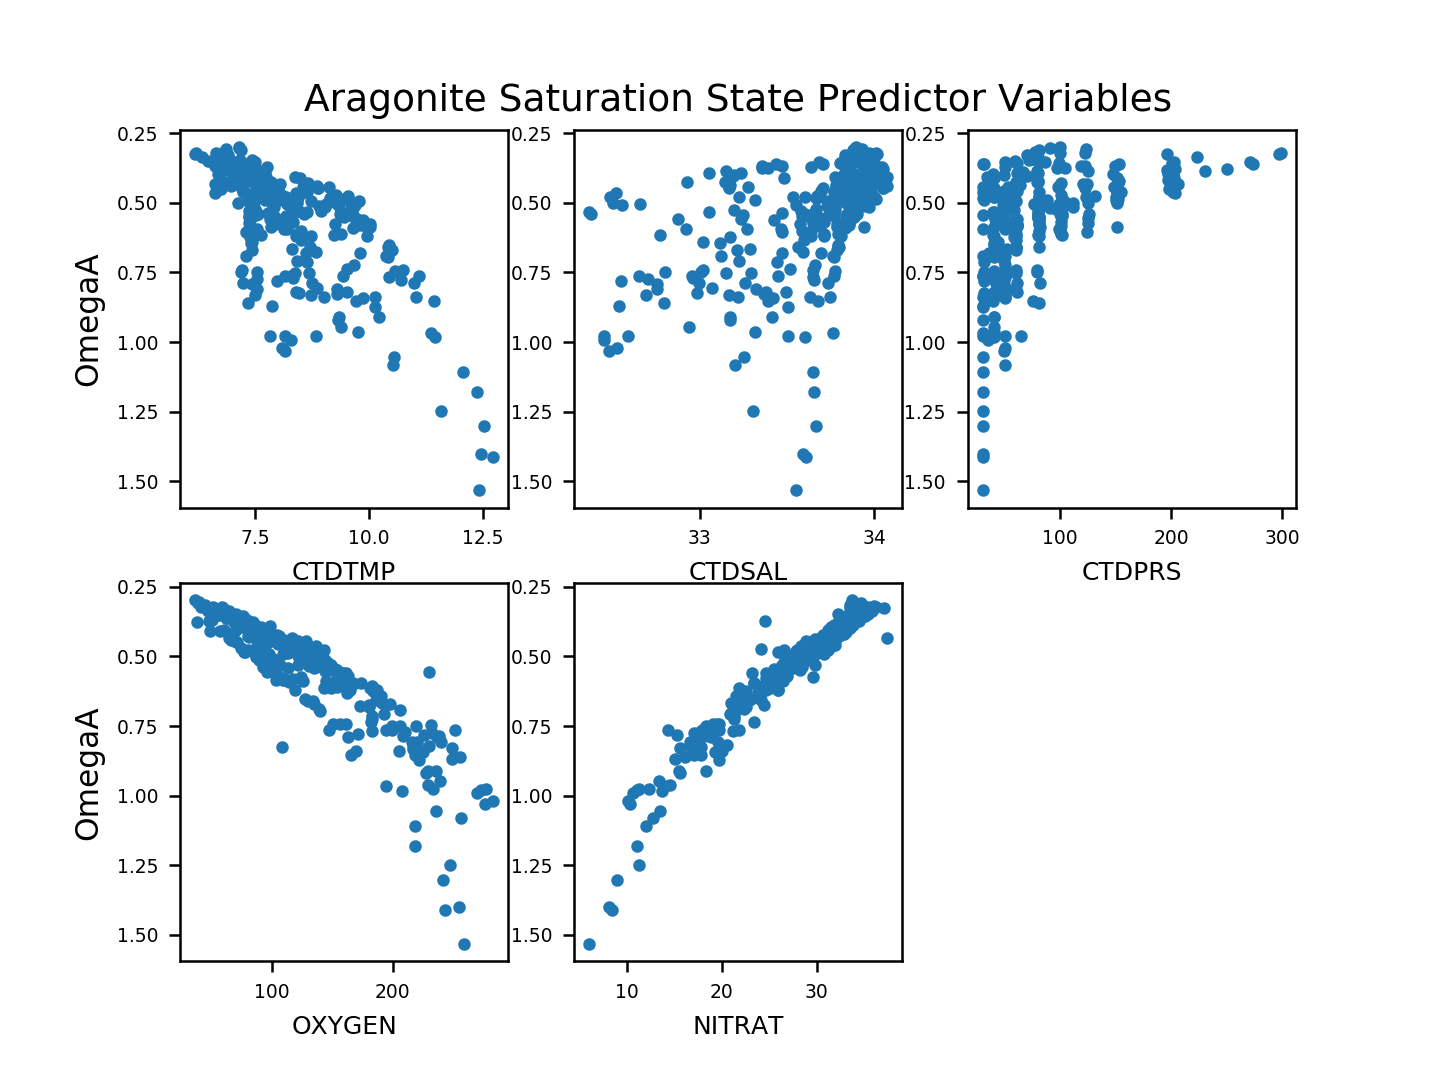

In [4]:
#Check out the relationships of each predictor variable with OmegaA
variables_to_plot = ['CTDTMP','CTDSAL','CTDPRS','OXYGEN','NITRAT']
plt.figure()

counter=0

for var in variables_to_plot:    
    counter = counter+1
    plt.subplot(2,3,counter)
    plt.plot(df[var][jj],df['OmegaA'][jj],'.')
    plt.gca().invert_yaxis()
    plt.xlabel(var,fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    if counter ==1 or counter ==4:
        plt.ylabel('OmegaA')
    if counter ==2:
        plt.title('Aragonite Saturation State Predictor Variables')


# Create two multiple linear regression models to calculate aragonite saturation state (OmegaA) as a function of more commonly observed variables

In [5]:
#Model 1: Temperature, salinity, pressure, dissolved oxygen and nitrate (same as class): 
#OmegaA = c0 + c1 x T + c2 x S + c3 x P + c5 x O + c6 x N

#find number of rows and columns of design matrix
rows = len(df['OmegaA'][jj])
columns1 = 6 #num of coefficients in model

#make an array of ones - start of the design matrix for above fit
Design1 = np.ones([rows,columns1]) 

#fill linearcomb with predictors
Design1[:,1]= df['CTDTMP'][jj]
Design1[:,2]= df['CTDSAL'][jj]
Design1[:,3]= df['CTDPRS'][jj]
Design1[:,4]= df['OXYGEN'][jj]
Design1[:,5]= df['NITRAT'][jj]

#use np.linalg.lstsq to compute set of coefficients
coefficients1 = np.linalg.lstsq(Design1,df['OmegaA'][jj])
print('Coefficients for 1st model: ',coefficients1[0])


#Model 2: Dissolved oxygen, and the interaction between oxygen and temperature (subtracting reference values): 
#OmegaA = c0 + c1 x (O - Oref) + c2 x (O - Oref)*(T - Tref)

#num of columns in Design matrix 2 = number of coefficients in fit
columns2 = 3

#define reference values for oxygen and temperature (from Jaranek paper) - data we are using is from a similar region
#so I assume these reference values are good. Units match that of our data.
Oref = 140 #deg C
Tref = 8 #micromols/kg

#make an array of ones - start of the design matrix for above fit
Design2 = np.ones([rows,columns2]) 

#fill linearcomb with predictors
Design2[:,1]= (df['OXYGEN'][jj] - Oref)
Design2[:,2]= (df['OXYGEN'][jj] - Oref)*(df['CTDTMP'][jj]-Tref)


#use np.linalg.lstsq to compute set of coefficients
coefficients2 = np.linalg.lstsq(Design2,df['OmegaA'][jj])
print('Coefficients for 2nd model: ',coefficients2[0])


Coefficients for 1st model:  [ -3.07750516e-01   3.19305644e-02   2.83171680e-02   1.99215122e-04
   1.13431498e-03  -1.92288348e-02]
Coefficients for 2nd model:  [ 0.57416519  0.00286187  0.00063884]


<IPython.core.display.Javascript object>


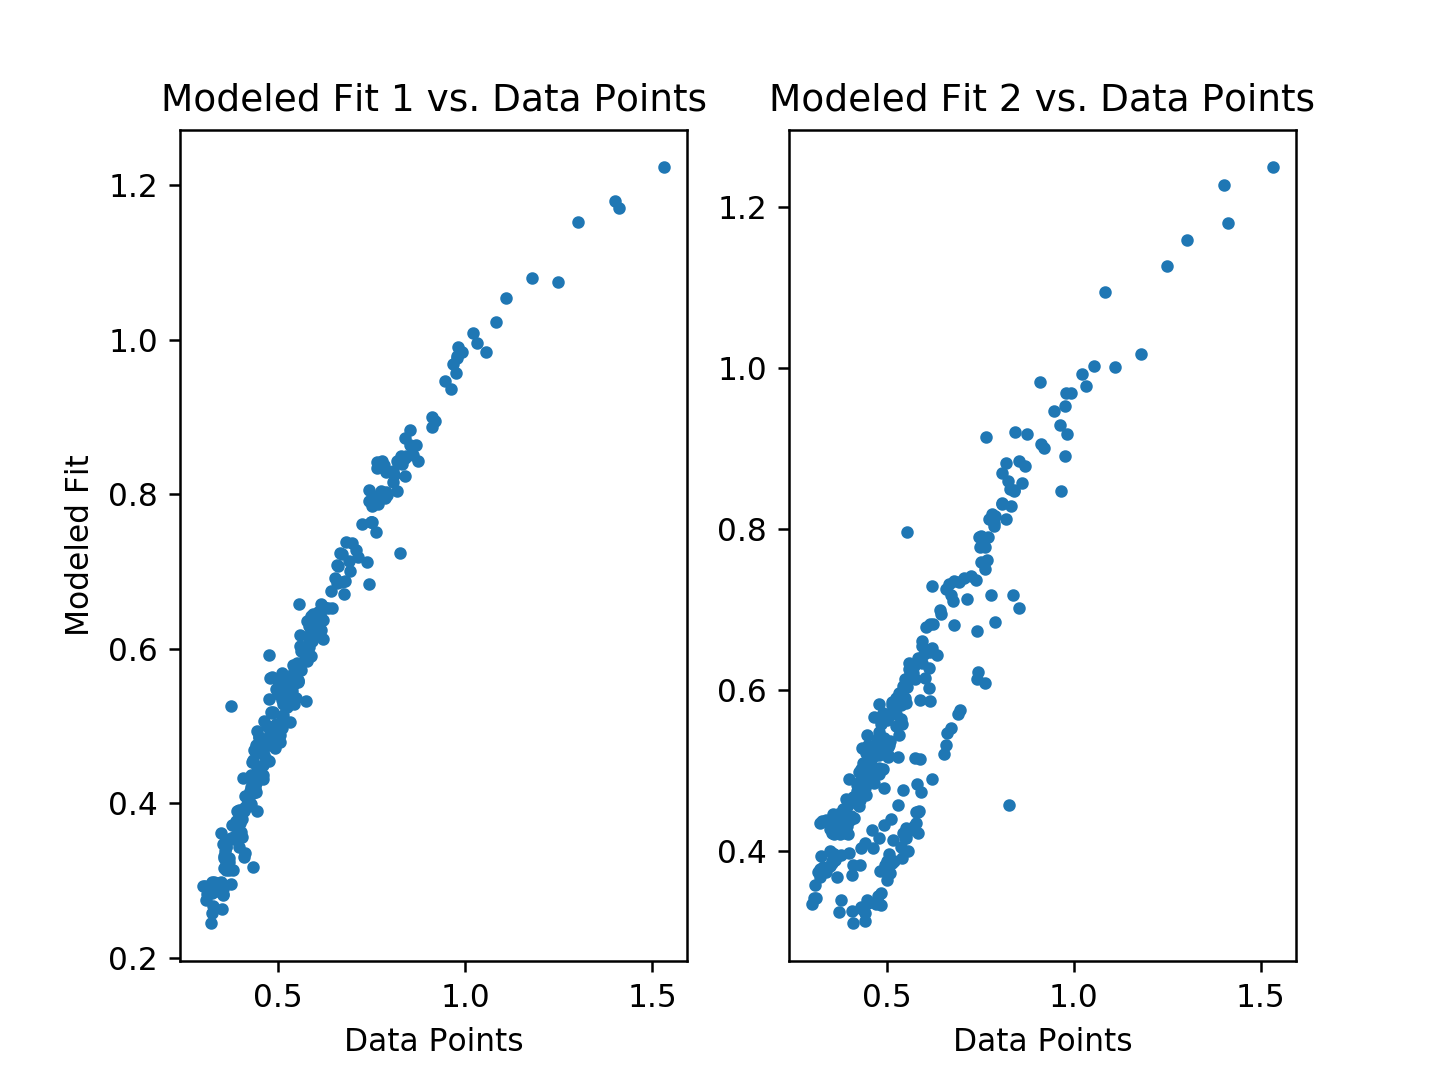

Text(0.5,0,'Data Points')

In [6]:
#plot modeled fit vs. data points
Model1 = np.dot(Design1,coefficients1[0])

plt.figure()
plt.subplot(1,2,1)
plt.plot(df['OmegaA'][jj],Model1,'.')
plt.title('Modeled Fit 1 vs. Data Points')
plt.xlabel('Data Points')
plt.ylabel('Modeled Fit')


#plot modeled fit vs. data points
Model2 = np.dot(Design2,coefficients2[0])

plt.subplot(1,2,2)
plt.plot(df['OmegaA'][jj],Model2,'.')
plt.title('Modeled Fit 2 vs. Data Points')
plt.xlabel('Data Points')


#model 2 appears more linear, which suggests it may be a better fit

<IPython.core.display.Javascript object>


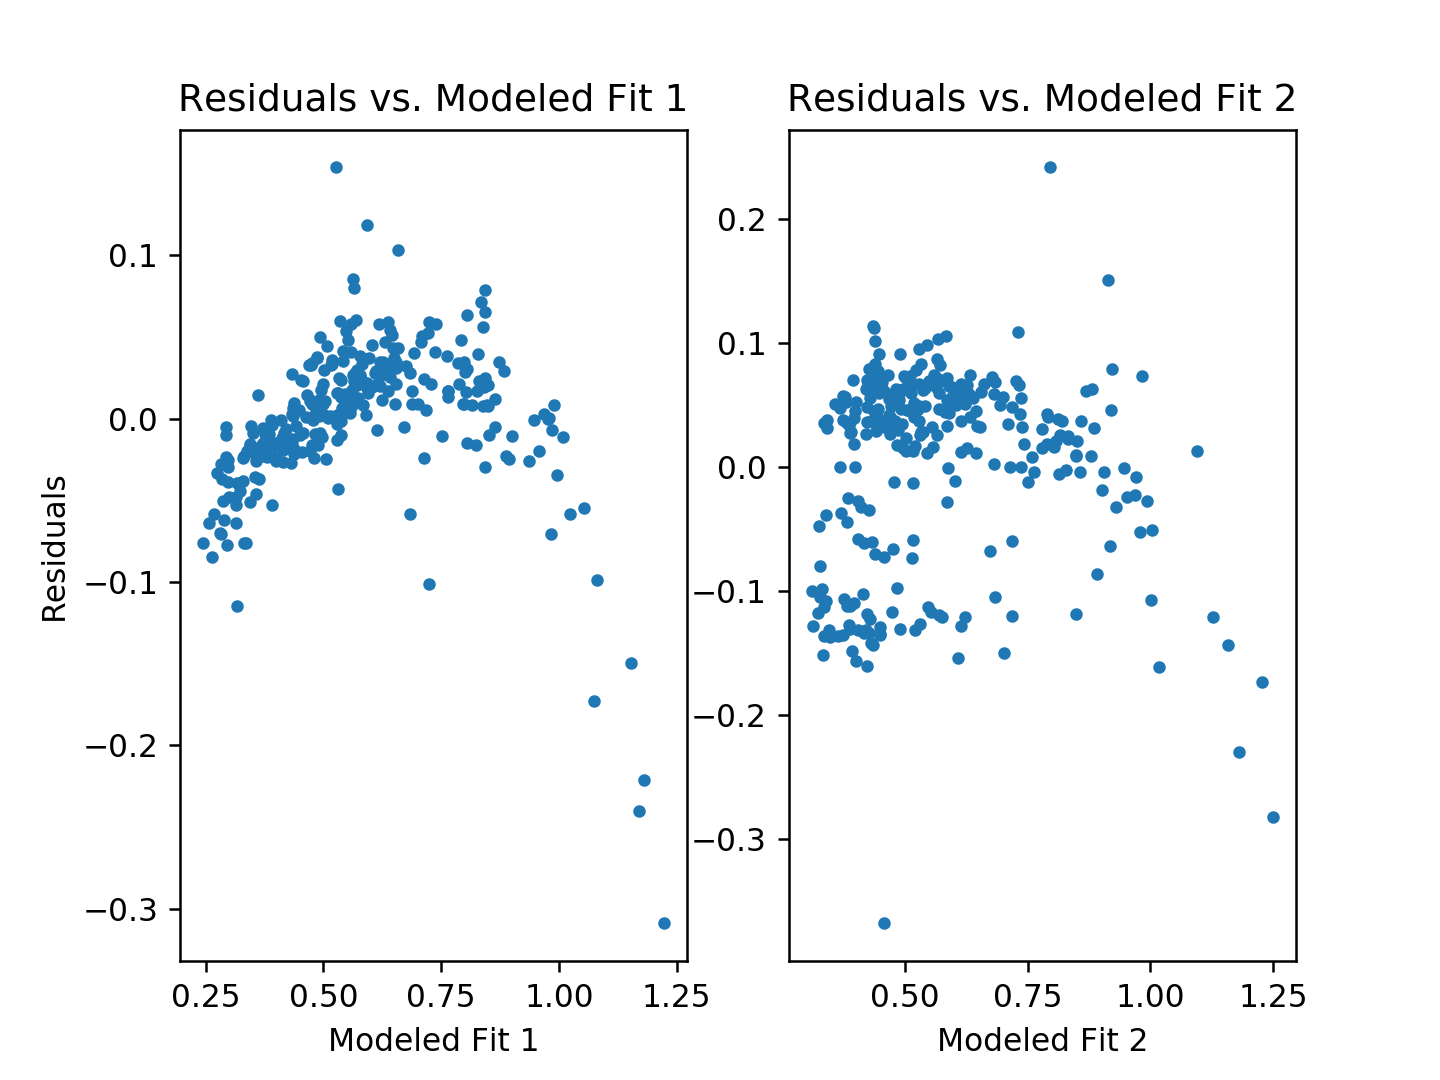

Text(0.5,0,'Modeled Fit 2')

In [14]:
#modeled fit vs. residuals 1
residuals1 = Model1-df['OmegaA'][jj]
plt.figure()
plt.subplot(1,2,1)
plt.title('Residuals vs. Modeled Fit 1')
plt.plot(Model1,residuals1,'.')
plt.xlabel('Modeled Fit 1')
plt.ylabel('Residuals')

#modeled fit vs. residuals 2
residuals2 = Model2-df['OmegaA'][jj]
plt.subplot(1,2,2)
plt.title('Residuals vs. Modeled Fit 2')
plt.plot(Model2,residuals2,'.')
plt.xlabel('Modeled Fit 2')

#model 2 appears to have more random residual values, which suggests it may be a better fit

In [8]:
#summary of regression results model 1
res = OLS(df['OmegaA'][jj],Design1).fit()
print('MODEL 1',res.summary())

MODEL 1                             OLS Regression Results                            
Dep. Variable:                 OmegaA   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          4.64e-182
Time:                        14:28:01   Log-Likelihood:                 478.59
No. Observations:                 290   AIC:                            -945.2
Df Residuals:                     284   BIC:                            -923.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3078      0.354     -0.870 

In [9]:
#summary of regression results model 2
res = OLS(df['OmegaA'][jj],Design2).fit()
print('MODEL 2', res.summary())

MODEL 2                             OLS Regression Results                            
Dep. Variable:                 OmegaA   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     793.2
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          1.22e-117
Time:                        14:28:01   Log-Likelihood:                 317.02
No. Observations:                 290   AIC:                            -628.0
Df Residuals:                     287   BIC:                            -617.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5742      0.005    112.448 

Compare the two regressions and comment on:

Statistical significance:
    To compare the statistical significance of the models, we can refer to the R-squared value. The first model has an R-squared value of .950 while the second has a value of .847. In other words, the first model accounts for 95% or the variance and the second model accounts for 84.7% of the variance so the first model may be better according to the R-squared value alone. We can also look to the F values - both models have extremely small F values, though the second model is larger, suggesting a smaller error in the second model. According to the F values alone, the second model may be better.     
   
Multiple co-linearity:
    To get at co-linearity, we can refer to the standard error associated with the coefficients in each equation. It appears that the second model has lower standard error associated with each coefficient than the first model. The higher error associated with variables in the first model may suggest co-linearity which can make it difficult to understand the effect of each of the predictor variables on OmegaA. With more variables in the first model, there is also a high variance inflation factor (VIF), not shown in the tables but discussed in the Juranek paper, which indicates high co-linearity. The high co-linearity can result in an inflated R-squared value as seen in the tables. 

Applicability of the model equations:
    In order to use the first model, you would need observations of temperature, salinity, pressure, oxygen, and nitrate. To use the second model, you would only need observations of oxygen and temperature and associated reference values for your region. Both models are predicting Aragonite saturation state, and since the second only needs two inputs and seems to avoid multiple co-linearity with fewer variables and yields a pretty good result, it seems that this one would be more applicable in a larger range of scenarios.
    
The potential for numerical errors:
    In the first model, we have 6 constants and in the second model we only have 3. Since multiplying by a constant number amplifies the relative uncertainty, the first model will have a higher potential for numerical errors.